In [2]:
import numpy as np
import pandas as pd
import numpy as np
# from cvxpy import *
import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

start_date = '2009-01-01'      
end_date = '2019-05-31'

m1 = M.instruments.v2(
    start_date=start_date,
    end_date=end_date,
    market='CN_STOCK_A',
    instrument_list=''
)

m7 = M.input_features.v1(
    features="""
beta_csi500_180_0
ta_mom_60_0
log(market_cap_0+0.0001)
west_eps_ftm_0/close_0
fs_net_income_0/market_cap_0
fs_eps_0/close_0
volatility_240_0
return_20
return_0
swing_volatility_240_0
fs_net_profit_qoq_0
fs_net_profit_yoy_0
fs_net_profit_0
west_netprofit_ftm_0
west_netprofit_ftm_0/market_cap_0
fs_operating_revenue_ttm_0/market_cap_0
fs_common_equity_0/market_cap_0
(fs_non_current_liabilities_0+market_cap_0)/market_cap_0
fs_total_liability_0/(fs_current_assets_0+fs_non_current_assets_0)
(fs_common_equity_0+fs_non_current_liabilities_0)/fs_common_equity_0
turn_0
"""
)

m8 = M.general_feature_extractor.v7(
    instruments=m1.data,
    features=m7.data,
    start_date='',
    end_date='',
    before_start_days=0
)

m9 = M.derived_feature_extractor.v3(
    input_data=m8.data,
    features=m7.data,
    date_col='date',
    instrument_col='instrument',
    drop_na=False,
    remove_extra_columns=False
)
 
# the material we need to build the factors are stored in Material DataFrame 
materials = m9.data.read_df()
materials = materials.set_index('date')

# materials.to_csv('D:/materialsStockData/materialsStockData.csv',index=True)

[2019-06-05 21:25:20.034692] INFO: bigquant: instruments.v2 开始运行..

[2019-06-05 21:25:20.097798] INFO: bigquant: 命中缓存

[2019-06-05 21:25:20.100103] INFO: bigquant: instruments.v2 运行完成[0.065411s].

[2019-06-05 21:25:20.105732] INFO: bigquant: input_features.v1 开始运行..

[2019-06-05 21:25:20.134342] INFO: bigquant: 命中缓存

[2019-06-05 21:25:20.136206] INFO: bigquant: input_features.v1 运行完成[0.030472s].

[2019-06-05 21:25:20.213705] INFO: bigquant: general_feature_extractor.v7 开始运行..

[2019-06-05 21:25:20.242639] INFO: bigquant: 命中缓存

[2019-06-05 21:25:20.244677] INFO: bigquant: general_feature_extractor.v7 运行完成[0.030973s].

[2019-06-05 21:25:20.257290] INFO: bigquant: derived_feature_extractor.v3 开始运行..

[2019-06-05 21:25:20.295581] INFO: bigquant: 命中缓存

[2019-06-05 21:25:20.297860] INFO: bigquant: derived_feature_extractor.v3 运行完成[0.040573s].

In [ ]:
'''
构建衍生因子
'''

In [3]:
# 构建十大类因子里面的所有小因子
# 流动性因子：stom,过去一个月日换手率之和的自然对数值;stoq,过去一个季度日换手率之和的自然对数值;stoa,过去一年日换手率之和的自然对数值
temporary_storage_dict = dict()
temporary_storage_dict['STOM'] = materials.groupby('instrument')['turn_0'].rolling(21).sum().apply(lambda x:np.log(x)).reset_index().set_index('date').rename(columns={'turn_0':'STOM'})
temporary_storage_dict['STOQ'] = temporary_storage_dict['STOM'].groupby('instrument').apply(lambda x:np.exp(x['STOM'])).rolling(3).mean().apply(lambda x:np.log(x)).reset_index().set_index('date').rename(columns={'STOM':'STOQ'})
temporary_storage_dict['STOA'] = temporary_storage_dict['STOM'].groupby('instrument').apply(lambda x:np.exp(x['STOM'])).rolling(12).mean().apply(lambda x:np.log(x)).reset_index().set_index('date').rename(columns={'STOM':'STOA'})

# 杠杆因子：mlev,市场杠杆,普通股市值+优先股账面值+长期负债账面值/普通股市值;dtoa,负债资产比;blev,账面杠杆,普通股账面值+优先股账面值+长期负债账面值/普通股账面值
temporary_storage_dict['MLEV'] = materials[['instrument','(fs_non_current_liabilities_0+market_cap_0)/market_cap_0']].rename(columns={'(fs_non_current_liabilities_0+market_cap_0)/market_cap_0':'MLEV'})
temporary_storage_dict['DTOA'] = materials[['instrument','fs_total_liability_0/(fs_current_assets_0+fs_non_current_assets_0)']].rename(columns={'fs_total_liability_0/(fs_current_assets_0+fs_non_current_assets_0)':'DTOA'})
temporary_storage_dict['BLEV'] = materials[['instrument','(fs_common_equity_0+fs_non_current_liabilities_0)/fs_common_equity_0']].rename(columns={'(fs_common_equity_0+fs_non_current_liabilities_0)/fs_common_equity_0':'BLEV'})

# 账面市值比因子：value,普通股账面值/普通股市值
temporary_storage_dict['Value'] = materials[['instrument','fs_common_equity_0/market_cap_0']].rename(columns={'fs_common_equity_0/market_cap_0':'Value'})

# 成长因子：growth,归母净利润同比增长率（有BUG,波动可能较大,估计不精确）
temporary_storage_dict['Growth'] = materials[['instrument','fs_net_profit_yoy_0']].rename(columns={'fs_net_profit_yoy_0':'Growth'})

# 盈利预期因子：epibs,cetop,分析师预期未来12月&历史12月盈利市值比;ETOP,历史12月现金流量市值比（有BUG）
temporary_storage_dict['EPIBS'] = materials[['instrument','west_eps_ftm_0/close_0']].rename(columns={'west_eps_ftm_0/close_0':'EPIBS'})
temporary_storage_dict['ETOP'] = materials[['instrument','fs_net_income_0/market_cap_0']].rename(columns={'fs_net_income_0/market_cap_0':'ETOP'})
temporary_storage_dict['CETOP'] = materials[['instrument','fs_eps_0/close_0']].rename(columns={'fs_eps_0/close_0':'CETOP'})

# 残差波动因子：dastd,过去12个月波动率;cmra,过去12个月对数超额收益率累加值序列的最大值减最小值;hsigma,CAPM模型过去12个月残差标准差（有BUG）
temporary_storage_dict['DASTD'] = materials[['instrument','volatility_240_0']].rename(columns={'volatility_240_0':'DASTD'})
temporary_storage_dict['GMRA'] = materials.groupby('instrument')['return_20'].rolling(12).apply(lambda x:np.log(1+np.max(x))-np.log(1+np.min(x))).reset_index().set_index('date').rename(columns={'return_20':'GMRA'})

# 市值因子：size,市值的自然对数
temporary_storage_dict['Size'] = materials[['instrument','log(market_cap_0+0.0001)']].rename(columns={'log(market_cap_0+0.0001)':'Size'})

# 动量因子：rstr,长期动量减去短期动量（有BUG）
temporary_storage_dict['Momentum'] = materials[['instrument','ta_mom_60_0']].rename(columns={'ta_mom_60_0':'Momentum'})

# 贝塔因子：beta,CAPM模型回归贝塔
temporary_storage_dict['Beta'] = materials[['instrument','beta_csi500_180_0']].rename(columns={'beta_csi500_180_0':'Beta'})

# 非线性市值 - 未构造完毕
temporary_storage_dict['Nlsize'] = temporary_storage_dict['Size'].copy().rename(columns={'Size':'Nlsize'})
temporary_storage_dict['Nlsize']['Nlsize'] = temporary_storage_dict['Size']['Size'].apply(lambda x: x**3)

In [3]:
instrument_list = list(set(materials['instrument'].tolist()))

In [6]:
'''
去极值处理
'''

'\n去极值处理\n'

In [6]:
# 去极值处理（截面）
def winsorize(df):
    factors = set(df.columns).difference(['date', 'instrument'])
    for factor in factors:
        # 某个时间截面上全是NaN
        if df[df[factor].isnull()==True].shape[0] == len(df):
            continue
        median = np.median(df[factor])
        MAD = np.median(np.abs(df[factor] - median))
        df[factor][df[factor]>median+5*MAD] = median+5*MAD  # 盖帽处理偏离中位数5倍以上的数据
        df[factor][df[factor]<median-5*MAD] = median-5*MAD
    return df

# 截面数据去极值,返回日频因子数据
extrema_remove_df = initiate_factor_df.groupby('date').apply(winsorize)  

In [10]:
'''
数据转为月度,行业数据拼接,因子缺失值截面行业均值填充,行业、市值中性化处理和标准化处理
'''

'\n数据转为月度,行业数据拼接,因子缺失值截面行业均值填充,行业、市值中性化处理和标准化处理\n'

In [7]:
# 读取行业数据和市值数据,并月度化
ins = list(extrema_remove_df.instrument.unique())
industry_info = D.history_data(ins, start_date, end_date, ['industry_sw_level1','market_cap_float'])   
industry_info['market_cap_float'] = np.log10(industry_info['market_cap_float'])  # 对市值因子取对数

industry_df = industry_info[(industry_info.industry_sw_level1!=0)&(industry_info.industry_sw_level1!=-1)].set_index('date')  # 取出其中有行业分类的条目，如果行业划分是0或者-1就算了，代表无划分

industry_df = industry_df.groupby('instrument').apply(lambda x: x.resample('M', how='last'))  
industry_df.index = industry_df.index.droplevel(0)
industry_df.reset_index(inplace=True)

In [8]:
# 风格因子数据转换成月度,并与市值行业数据的拼接,并把行业因子转换成dummy数据 
extrema_remove_df.set_index('date', inplace=True)
extrema_remove_df = extrema_remove_df.groupby('instrument').apply(lambda x: x.resample('M', how='last'))  # pandas 处理时间序列数据，将原始数据转换为月末数据
extrema_remove_df.index = extrema_remove_df.index.droplevel(0) # 有多重index,丢弃股票代码index（来自groupby）
extrema_remove_df.reset_index(inplace=True)

extrema_remove_df = extrema_remove_df.merge(industry_df, on=['date', 'instrument']) # 风格因子数据和市值行业数据拼接

# 截面因子缺失值数据使用行业均值填充
extrema_remove_df = extrema_remove_df.groupby(['date', 'industry_sw_level1']).apply(lambda t: t.fillna(np.mean(t, axis=0)))
extrema_remove_df.reset_index(inplace=True, drop=True)

# 行业属性数据哑变量
dummy_industry_df = pd.get_dummies(extrema_remove_df['industry_sw_level1'], prefix='industry_prefix')   

# 哑变量与截面数据进行横向拼接
merge_df = pd.concat([extrema_remove_df, dummy_industry_df], axis=1).sort_values(['date', 'instrument'])  # 原始的行业因子那列应该还在

In [9]:
# 行业中性化处理和市值中性化处理 - 正交
def calcu_single_factor(df, factor):
    # 行业哑变量
    industry_factor = [i for i in df.columns if i[:15]=='industry_prefix']
    # 对市值因子和行业因子进行回归
    xvars = ['market_cap_float'] + industry_factor
    used_factors = xvars + [factor] + ['instrument']
    
    used_factors_df = df[used_factors]
    used_factors_df = used_factors_df[~used_factors_df.isnull().T.any().T]
    if len(used_factors_df) == 0:
        return None
    X = used_factors_df[xvars]
    y = used_factors_df[factor]
    reg = LinearRegression()
    try:
        reg.fit(X,y)   # 将行业因子因子和市值因子对特定因子作回归
        res = y-reg.predict(X)
        used_factors_df[factor] = res
    except ValueError as e:
        used_factors_df[factor] = np.nan 

    return used_factors_df[['instrument',factor]]

detail_style_factor = [m for m in initiate_factor_df.columns if m not in ['date','instrument','market_cap_float']]  

# 对风格因子进行市值中性化处理,共计16个风格因子
# 对每个因子,在时间截面上处理
factor_data_after_neutralize = pd.DataFrame(columns=['date','instrument'])
for factor in detail_style_factor: 
    result_temp = merge_df.groupby('date').apply(lambda x: calcu_single_factor(x, factor)).reset_index().drop('level_1',axis=1)
    factor_data_after_neutralize = factor_data_after_neutralize.merge(result_temp, on=['date', 'instrument'], how='outer') # 因为是拼接,每次都取并集,第一次相当于填充

# 标准化处理
def standardlize(x):
    return (x-x.mean())/x.std()
for factor in detail_style_factor:
    factor_data_after_neutralize[factor] = factor_data_after_neutralize.groupby('date')[factor].apply(standardlize)

# 用0值填充标准化后的缺失值 
factor_data_after_standard = factor_data_after_neutralize.fillna(0)

In [15]:
'''
获取股票价格数据
'''

'\n获取股票价格数据\n'

In [10]:
# 获取股票价格并月度化 - 从已经构造好的因子数据集获取时间以及标的信息
start = factor_data_after_standard.date.min().strftime('%Y-%m-%d')   
end = factor_data_after_standard.date.max().strftime('%Y-%m-%d')      
ins = list(set(factor_data_after_standard.instrument))    

price = DataSource('bar1d_CN_STOCK_A').read(instrument=ins, start_date=start, end_date=end, fields=['close'])    
price.rename(columns={'close':'price'}, inplace=True)
price = price.set_index('date').groupby('instrument').apply(lambda x: x.resample('M', how='last'))    
price.index = price.index.droplevel(0)
price.reset_index(inplace=True)

In [17]:
'''
数据透视表计算股票收益率与因子数据合并
'''

'\n数据透视表计算股票收益率与因子数据合并\n'

In [11]:
# 通过价格计算收益率并合成大类风格因子
tmp_factor = [m for m in merge_df.columns if m not in ['market_cap_float','industry_sw_level1']]
industry_prefix_factor = list(set(tmp_factor).difference(set(detail_style_factor)))  # industry_prefix_factor  是date instrument 和行业因子,共计30个因子

# 构建一个总的数据表, 合并行业因子和价格
monthly_style_and_industry_factor = factor_data_after_standard.merge(price, on=['date', 'instrument'], how='inner')
monthly_style_and_industry_factor = monthly_style_and_industry_factor.merge(merge_df[industry_prefix_factor], on=['date', 'instrument'], how='inner').set_index('date')  

# 计算出收益率 - 需要注意,月度收益率若为T~T+1期的收益,则标记时间为T,因为与因子对应的收益率数据是下一期收益
monthly_style_and_industry_factor.reset_index(inplace=True)

monthly_price_df = monthly_style_and_industry_factor.pivot_table(values='price',columns='instrument',index='date')
# monthly_style_and_industry_factor = monthly_style_and_industry_factor.merge(monthly_price_df.pct_change().shift(-1).unstack(
#                               ).to_frame('return').reset_index(),on=['date','instrument']) # 这里的shift(-1)很关键
monthly_style_and_industry_factor = monthly_style_and_industry_factor.merge(monthly_price_df.pct_change().shift(-1).unstack(
                              ).reset_index().rename(columns={0:'return'}),on=['date','instrument']) # 这里的shift(-1)很关键
monthly_style_and_industry_factor = monthly_style_and_industry_factor.dropna()

In [93]:
print(merge_df.columns,'\n')
print(factor_data_after_standard.columns)

Index(['date', 'instrument', 'STOM', 'Size', 'Beta', 'GMRA', 'Growth', 'BLEV',
       'STOQ', 'Momentum', 'ETOP', 'DTOA', 'DASTD', 'MLEV', 'Value', 'EPIBS',
       'STOA', 'CETOP', 'industry_sw_level1', 'market_cap_float',
       'industry_prefix_110000', 'industry_prefix_210000',
       'industry_prefix_220000', 'industry_prefix_230000',
       'industry_prefix_240000', 'industry_prefix_270000',
       'industry_prefix_280000', 'industry_prefix_330000',
       'industry_prefix_340000', 'industry_prefix_350000',
       'industry_prefix_360000', 'industry_prefix_370000',
       'industry_prefix_410000', 'industry_prefix_420000',
       'industry_prefix_430000', 'industry_prefix_450000',
       'industry_prefix_460000', 'industry_prefix_480000',
       'industry_prefix_490000', 'industry_prefix_510000',
       'industry_prefix_610000', 'industry_prefix_620000',
       'industry_prefix_630000', 'industry_prefix_640000',
       'industry_prefix_650000', 'industry_prefix_710000',
       'in

In [ ]:
'''
小类因子合并为大类因子 - 比较灵活
'''

In [12]:
# 小因子等权重合并成大因子, 这里未来可以采取IC_IR法
monthly_style_and_industry_factor['Volatility'] = (monthly_style_and_industry_factor['DASTD']+monthly_style_and_industry_factor['GMRA'])/2
# monthly_style_and_industry_factor['Volatility'] = monthly_style_and_industry_factor['dastd']
monthly_style_and_industry_factor['EarningYields'] = (monthly_style_and_industry_factor['EPIBS']+monthly_style_and_industry_factor['ETOP']+monthly_style_and_industry_factor['CETOP'])/3
monthly_style_and_industry_factor['Leverage'] = (monthly_style_and_industry_factor['MLEV']+monthly_style_and_industry_factor['BLEV']+monthly_style_and_industry_factor['DTOA'])/3
monthly_style_and_industry_factor['Liquidity'] = (monthly_style_and_industry_factor['STOM']+monthly_style_and_industry_factor['STOQ']+monthly_style_and_industry_factor['STOA'])/3
monthly_style_and_industry_factor.drop(['DASTD','GMRA','EPIBS','ETOP','CETOP','MLEV','BLEV','DTOA','STOM','STOQ','STOA'], axis=1, inplace=True)

In [58]:
monthly_style_and_industry_factor.columns

Index(['date', 'instrument', 'STOM', 'MLEV', 'Size', 'Momentum', 'EPIBS',
       'GMRA', 'ETOP', 'Nlsize', 'Beta', 'BLEV', 'dastd', 'Value', 'CETOP',
       'STOA', 'STOQ', 'Growth', 'DTOA', 'DASTD', 'price',
       'industry_prefix_490000', 'industry_prefix_710000',
       'industry_prefix_420000', 'industry_prefix_620000',
       'industry_prefix_430000', 'industry_prefix_510000',
       'industry_prefix_240000', 'industry_prefix_350000',
       'industry_prefix_370000', 'industry_prefix_460000',
       'industry_prefix_480000', 'industry_prefix_230000',
       'industry_prefix_450000', 'industry_prefix_110000',
       'industry_prefix_730000', 'industry_prefix_270000',
       'industry_prefix_410000', 'industry_prefix_640000',
       'industry_prefix_220000', 'industry_prefix_650000',
       'industry_prefix_210000', 'industry_prefix_360000',
       'industry_prefix_720000', 'industry_prefix_610000',
       'industry_prefix_340000', 'industry_prefix_330000',
       'industry_prefix_

In [ ]:
'''
计算股票特质收益率
'''

In [13]:
style_factor = ['Value','Growth','Size','Beta','Momentum','Volatility','EarningYields','Leverage','Liquidity','Nlsize']

In [ ]:
'''
与Barra无关内容 - LSC
输入一个数据表：列至少包括因子+收益率（下期）+收盘价+股票名称+日期的面板堆叠数据表,已经完成缩尾、标准化、填补缺失值处理
输出IC、RankIC序列、多空组合收益序列
结果的日期是因子数据提取的日期
'''

In [14]:
analysis_used_df = monthly_style_and_industry_factor[style_factor+['date','instrument','return']]

analysis_used_df_groupby_date = analysis_used_df.groupby('date')
analysis_factor_list = set(analysis_used_df.columns).difference(['date','instrument','return'])

## IC、RankIC序列计算,均值输出
def IC_get(df):
    corr_coef = df[[factor,'return']].corr().iloc[0,1]
    return pd.DataFrame([corr_coef],columns=['IC'+factor])

def RankIC_get(df):
    tmp_df = df[[factor,'return']]
    for col in [factor,'return']:
        tmp_df = tmp_df.sort_values(col)
        tmp_df[col] = range(1,len(tmp_df)+1)
    corr_coef = tmp_df.corr().iloc[0,1]
    return pd.DataFrame([corr_coef],columns=['RankIC'+factor])

IC_save_df = pd.DataFrame(columns=['date'])
for index_compute in [IC_get,RankIC_get]:
    for factor in analysis_factor_list:
        IC_save_df_tmp = analysis_used_df_groupby_date.apply(index_compute)
        IC_save_df_tmp.index = IC_save_df_tmp.index.droplevel(1)
        IC_save_df_tmp = IC_save_df_tmp.reset_index()
        IC_save_df = IC_save_df.merge(IC_save_df_tmp,on=['date'],how='outer')
print(pd.DataFrame(IC_save_df.mean(),columns=['ICmean']).sort_values('ICmean',ascending=True).head(10))
print(pd.DataFrame(IC_save_df.mean(),columns=['ICmean']).sort_values('ICmean',ascending=False).head(10))

## 因子首尾多空组合收益率计算,均值输出
Factor_portfolio_save_df = pd.DataFrame(columns=['date'])
def Factor_portfolio(df,N):
    tmp_df = df[[factor,'return']]
    tmp_df_L = tmp_df[tmp_df[factor] >= tmp_df[factor].quantile(1-1/N)]
    tmp_df_S = tmp_df[tmp_df[factor] <= tmp_df[factor].quantile(1/N)]
    L_return = tmp_df_L['return'].mean()
    S_return = tmp_df_S['return'].mean()
    LS_return = L_return - S_return
    return pd.DataFrame({'LS'+factor:[LS_return],'L'+factor:[L_return],'S'+factor:[S_return]})
for factor in analysis_factor_list:
    Factor_portfolio_save_df_tmp = analysis_used_df_groupby_date.apply(lambda x: Factor_portfolio(x,5))
    Factor_portfolio_save_df_tmp.index = Factor_portfolio_save_df_tmp.index.droplevel(1)
    Factor_portfolio_save_df_tmp = Factor_portfolio_save_df_tmp.reset_index()
    Factor_portfolio_save_df = Factor_portfolio_save_df.merge(Factor_portfolio_save_df_tmp,on=['date'],how='outer')
print(pd.DataFrame(Factor_portfolio_save_df.mean(),columns=['PortfolioRmean']).sort_values('PortfolioRmean',ascending=True).head(10))
print(pd.DataFrame(Factor_portfolio_save_df.mean(),columns=['PortfolioRmean']).sort_values('PortfolioRmean',ascending=False).head(10))

                    ICmean
RankICLiquidity  -0.106133
ICLiquidity      -0.087979
RankICVolatility -0.058573
RankICSize       -0.040310
ICVolatility     -0.031172
ICSize           -0.023537
RankICMomentum   -0.021796
RankICBeta       -0.019405
ICBeta           -0.014514
ICMomentum       -0.002984
                       ICmean
RankICNlsize         0.055935
ICNlsize             0.053276
RankICValue          0.049014
RankICEarningYields  0.033809
ICValue              0.029278
ICEarningYields      0.025957
RankICGrowth         0.022443
RankICLeverage       0.010008
ICLeverage           0.009247
ICGrowth             0.004499
              PortfolioRmean
LSLiquidity        -0.029416
LSVolatility       -0.010852
LSSize             -0.007092
LSBeta             -0.006139
LLiquidity          0.001431
LSMomentum          0.001734
LSGrowth            0.006723
LSLeverage          0.008622
SValue              0.009273
LVolatility         0.009374
                PortfolioRmean
LNlsize               0

In [ ]:
'''
与Barra无关内容 -LSC
计算多因子模型对未来收益截面解释力度 Rsquare
因子T期,收益T~T+1
'''

In [18]:
# 在每个时间截面上,收益率对因子回归(这里包括十大风格因子和行业因子), 通过回归计算出每个时间截面的回归Rsquare,得到序列
# style_factor = ['Value','Growth','Size','Beta','Momentum','Volatility','EarningYields','Leverage','Liquidity','Nlsize']

def calcu_model_rsquare(df):
    xvars = list(set(df.keys()).difference(['date','instrument','return','price']))
    X = df[xvars]
    y = df['return']
    reg = LinearRegression()
    try:
        reg.fit(X,y)
        score = reg.score(X,y)
    except ValueError as e:
        score = np.nan 

    return pd.DataFrame({'Rsquare':[score]})

rsquare_df = monthly_style_and_industry_factor.groupby('date').apply(calcu_model_rsquare)
rsquare_df.index = rsquare_df.index.droplevel(1)
# rsquare_df = rsquare_df.sort_values('date').set_index('date')

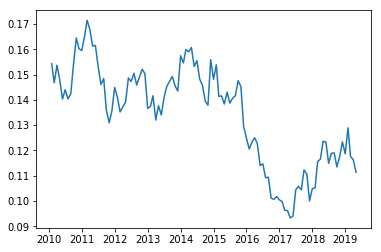

In [23]:
import matplotlib.pyplot as plt
plt.plot(rsquare_df.rolling(12).mean())
plt.show()

In [ ]:
'''
与Barra无关内容 - LSC
因子拥挤度计算
衡量因子被过度追踪的情况
数据均用expanding 标准化,故最开始几期参考意义不大
1.估值价差 - ln(Q1 B/P 中位数)/ (Q5 B/P 中位数)~标准化 + ln(Q1 S/P 中位数)/ (Q5 S/P 中位数)~标准化 + (Q1 E/P 中位数)-(Q5 E/P 中位数)~标准化
2.配对相关
3.因子波动
4.因子反转
'''

In [15]:
def expanding_standarlize(df):
    '''
    输入具有多列的df,多列时间序列数据,index为日期'date',进行expanding标准化,均值用各列expanding均值,标准差用平均值
    '''
    df = df.copy()
    spread_name = df.columns.tolist()
    spread_mean_name = [i+'_mean' for i in spread_name]
    # 防止未来数据影响,时间序列标准化用expanding标准化
    value_spread_mean = df.expanding().mean()
    value_spread_mean.columns = spread_mean_name
    # 所除标准差是三子类指标平均标准差 - 保留了一定的相对差异
    value_spread_std = df.expanding().std()
    value_spread_avgstd = pd.DataFrame(value_spread_std.mean(axis=1),columns=['avgstd'])
    
    value_spread_df = df.merge(value_spread_mean,left_index=True,right_index=True).merge(value_spread_avgstd,left_index=True,right_index=True)
    # 标准化
    for name in spread_name:
        value_spread_df[name] = value_spread_df.apply(lambda x: (x[name]-x[name+'_mean'])/x['avgstd'],axis=1)
        
    return value_spread_df[spread_name]

In [ ]:
'''
1.估值价差
ln(Q1 B/P 中位数)/(Q5 B/P 中位数)~标准化 + 
ln(Q1 S/P 中位数)/(Q5 S/P 中位数)~标准化 + 
(Q1 E/P 中位数)-(Q5 E/P 中位数)~标准化

Data
west_netprofit_ftm_0/market_cap_0 - E/P
fs_operating_revenue_ttm_0/market_cap_0 - S/P
fs_common_equity_0/market_cap_0 - B/P
'''

In [16]:
analysis_used_df = monthly_style_and_industry_factor[style_factor+['date','instrument','return']].reset_index()
materials_temp = materials.groupby('instrument').apply(lambda x: x.resample('M',how='last'))
materials_temp.index = materials_temp.index.droplevel(0)
materials_temp.reset_index(inplace=True)
analysis_used_df = analysis_used_df.merge(materials_temp,on=['date','instrument'],how='left')
analysis_factor_list = style_factor

In [17]:
def Crowding_value_spread(df,N,factor):
    '''
    对某一天的数据,计算某因子的估值价差指标的三个子类指标,输出dataframe,主函数的辅助函数
    '''  
    tmp_df = df.copy()
    tmp_df_L = tmp_df[tmp_df[factor] >= tmp_df[factor].quantile(1-1/N)]
    tmp_df_S = tmp_df[tmp_df[factor] <= tmp_df[factor].quantile(1/N)]
    Top_median_BP = tmp_df_L['fs_common_equity_0/market_cap_0'].median()
    Bottom_median_BP = tmp_df_S['fs_common_equity_0/market_cap_0'].median()
    Top_median_EP = tmp_df_L['west_netprofit_ftm_0/market_cap_0'].median()
    Bottom_median_EP = tmp_df_S['west_netprofit_ftm_0/market_cap_0'].median()
    Top_median_SP = tmp_df_L['fs_operating_revenue_ttm_0/market_cap_0'].median()
    Bottom_median_SP = tmp_df_S['fs_operating_revenue_ttm_0/market_cap_0'].median()
    BP_spread = np.log(Bottom_median_BP/Top_median_BP)
    EP_spread = Bottom_median_EP - Top_median_EP
    SP_spread = np.log(Bottom_median_SP/Top_median_SP)
    return pd.DataFrame({'BP_spread':[BP_spread],'EP_spread':[EP_spread],'SP_spread':[SP_spread]})

def Crowding_value_spread_all(analysis_used_df,analysis_factor_list):
    '''
    主函数,
    输入dataframe,包含月度因子数据,列为因子+股票代码+日期,
    输入factor_list,需计算拥挤度的因子列表,
    输出每个因子的月度因子拥挤度序列.
    '''
    value_spread_save_df = pd.DataFrame()
    for factor in analysis_factor_list:
        value_spread = analysis_used_df.groupby('date').apply(lambda x: Crowding_value_spread(x,5,factor))
        value_spread.index = value_spread.index.droplevel(1)
        # expanding标准化
        value_spread_df = expanding_standarlize(value_spread)
        # 各因子估值价差序列拼接
        value_spread_save_df = value_spread_save_df.merge(pd.DataFrame(value_spread_df.mean(axis=1),columns=[factor]),how='outer',left_index=True,right_index=True)
    return value_spread_save_df 
    
# 标准化供多拥挤度指标相加,均值使用expandingFactorSpecial,标准差统一用expandingFactorSpecialStd的均值
value_spread_save_df = Crowding_value_spread_all(analysis_used_df,analysis_factor_list)
value_spread_save_df_afterS = expanding_standarlize(value_spread_save_df)

In [35]:
value_spread_save_df_afterS.iloc[-1,]

Value_value_spread           -0.097692
Growth_value_spread          -1.691855
Size_value_spread            -0.747761
Beta_value_spread            -0.709479
Momentum_value_spread         0.430857
Volatility_value_spread      -2.159794
EarningYields_value_spread    0.356802
Leverage_value_spread        -0.214669
Liquidity_value_spread       -1.230333
Nlsize_value_spread          -0.190470
Name: 2019-04-30 00:00:00, dtype: float64

In [ ]:
'''
2.配对相关
Q1&Q5收益(截面)均值序列
Q1&Q5股票对相应收益均值序列计算trailing63天相关系数,各自求平均值
美股是两个相关系数再求和作为拥挤度代理变量之一,
A股应当改成Q5-Q1,衡量多头相对于尾部的异常同涨同跌,尾部无法做空不会出现同涨同跌。

Data
return_0 -> 1+r!

PS
数据透视表在这一部分可用,在月度时间截面上要获取trailing63天的收益率数据计算corr是一个单变量面板数据,使用pivot很方便
'''

In [ ]:
# 日度的因子数据以及收益率数据供时间截面上正交 - 不运行
pair_col_used_df = pd.merge(initiate_factor_df, materials.reset_index(),on=['date','instrument'])

# 首先计算特质收益率,对市场(常数项1)、规模、贝塔、残差波动率正交 - 未运行、耗时过长

def calcu_factor_specified_return(df):
    xvars = ['Size','Beta','Volatility']
    X = df[xvars]
    y = df['return_0']-1
    reg = LinearRegression(fit_intercept=True)
    try:
        reg.fit(X,y)
        res = y-reg.predict(X)
        df['specified_return'] = res
    except ValueError as e:
        df['specified_return'] = np.nan 

    return df

residual_ret_daily = pair_col_used_df.groupby('date').apply(calcu_factor_specified_return)
# residual_ret_daily = residual_ret_daily[['instrument', 'date', 'specified_return']]
# residual_ret_daily = residual_ret.sort_values('date').set_index('date')

In [18]:
# 用普通的日度收益率代替
col_pair_return_df = materials.copy()
# 因子数据所用df
col_pair_factor_df = monthly_style_and_industry_factor[style_factor+['instrument','date']].copy()
# 所用因子列表
factor_list = style_factor

In [21]:
def Crowding_pair_cor(col_pair_return_df,col_pair_factor_df,factor_list):
    '''
    主函数,
    输入两个dataframe,
    col_pair_return_df,具有样本期内股票的日度收益率(close/closepre),若是(close0/closepre)-1需要改写内容,列为日期+股票代码+收益率
    col_pair_factor_df,具有样本期内股票的月度因子数据,列为日期+股票代码+因子,
    factor_list,所用因子列表,
    输出每个因子配对相关系数序列
    '''
    # 样本期内全交易日列表
    all_trade_day_list = materials.index.unique()

    # 每个月计算每个因子的拥挤度,因为要trailing63天,约3月,从第四个月开始计算保证足够样本
    end_month_date_list = np.sort(list(set(monthly_style_and_industry_factor.date)))[3::]

    # 计算出风格因子收益率 
    cor_pair = pd.DataFrame()
    for dt in end_month_date_list:
        # 对一个时间截面上,欲求所有因子的配对相关系数
        col_pair_factor_df_sub = col_pair_factor_df[col_pair_factor_df['date'] == dt]
        # trailing 63个 交易日
        dt_start = [date_ for date_ in all_trade_day_list if date_<=dt][-63]
        col_pair_return_df_sub = col_pair_return_df[(col_pair_return_df.index>=dt_start) & (col_pair_return_df.index<=dt)]
        col_pair_return_df_sub = col_pair_return_df_sub.reset_index()
        factor_cor_pair_dict = {}
        for factor in factor_list:
            L_list = col_pair_factor_df_sub[col_pair_factor_df_sub[factor] >= col_pair_factor_df_sub[factor].quantile(1-1/5)]['instrument'].unique().tolist()
            S_list = col_pair_factor_df_sub[col_pair_factor_df_sub[factor] <= col_pair_factor_df_sub[factor].quantile(1/5)]['instrument'].unique().tolist()
            # 数据透视表,将收益率展开
            time_cross_return = col_pair_return_df_sub.pivot_table(index='date',columns='instrument',values='return_0')
            # 计算多头以及空头组合个股与均值收益率的平均相关系数 - 取组合要先对个股列表取交集
            corr_save = []
            for list_uesd in [L_list,S_list]:

                list_sub = [each for each in list_uesd if each in time_cross_return.columns.tolist()]
                time_cross_return_used = time_cross_return[list_sub].apply(lambda x: x-1)
                time_cross_return_used['avg_return'] = time_cross_return_used.mean(axis=1)
                corr_used = time_cross_return_used.corr().sum()['avg_return']/len(list_uesd)
                corr_save.append(corr_used)
            # 多头减空头作为当期该因子拥挤度
            factor_cor_pair = corr_save[0] - corr_save[1]
            factor_cor_pair_dict[factor] = factor_cor_pair
        cor_pair = pd.concat([cor_pair,pd.DataFrame(factor_cor_pair_dict,index=[dt])],axis=0)   
    cor_pair = cor_pair.reset_index().rename(columns={'index':'date'}).sort_values('date').set_index('date')
    return cor_pair

# 获得每个因子配对相关系数,标准化
cor_pair = Crowding_pair_cor(col_pair_return_df,col_pair_factor_df,factor_list)
cor_pair_afterS = expanding_standarlize(cor_pair)

In [36]:
cor_pair_afterS.iloc[-1,]

Beta_pair_cor            -2.648936
EarningYields_pair_cor   -0.344082
Growth_pair_cor          -0.462005
Leverage_pair_cor         0.329982
Liquidity_pair_cor        1.244004
Momentum_pair_cor         0.144510
Nlsize_pair_cor           0.504375
Size_pair_cor             1.413901
Value_pair_cor           -0.026417
Volatility_pair_cor       0.202786
Name: 2019-04-30 00:00:00, dtype: float64

In [ ]:
'''
3.因子反转 - shift()的时候切记日期放入index,否则会一起shift
因子过去3年(原文,练习时用1.5年,因为样本时间较短)累计收益率,
因子收益率使用多空组合,大因子组合减去小因子组合收益率
'''

In [22]:
# 因子数据所用df - 来自计算IC序列的多空组合收益结果,收益率的日期是下一期收益需要往后移动一期
reversal_factor_df = Factor_portfolio_save_df.set_index('date').shift(1).reset_index()
# 因子列表
reversal_factor_list = style_factor

In [23]:
def Crowding_factor_reversal(reversal_factor_df,reversal_factor_list):
    '''
    主函数,
    输入来自计算IC序列的结果之一月度多空组合收益,dataframe,列为'LS因子'命名的多空组合+date,
    输出因子反转指标df.
    '''
    reversal_factor = reversal_factor_df[['LS'+f for f in reversal_factor_list]+['date']].set_index('date').rolling(18).sum().dropna(how='any')
    reversal_factor.columns = reversal_factor_list
    return reversal_factor

In [24]:
# 标准化
reversal_factor = Crowding_factor_reversal(reversal_factor_df,reversal_factor_list)
reversal_factor_afterS = expanding_standarlize(reversal_factor)

In [62]:
reversal_factor_afterS.iloc[-1,]

Value_reversal           -0.277511
Growth_reversal          -0.552043
Size_reversal            -1.216897
Beta_reversal             1.583220
Momentum_reversal         0.272641
Volatility_reversal       0.903312
EarningYields_reversal   -1.363202
Leverage_reversal        -0.752317
Liquidity_reversal        0.612529
Nlsize_reversal          -0.162439
Name: 2019-04-30 00:00:00, dtype: float64

In [ ]:
'''
4.因子波动
Q1&Q5过去126个交易日个股收益波动,
使用多组合个股收益率标准差均值比空组合个股收益率标准差均值(简便计算,不计算协方差矩阵了,相关关系在配对相关中有反映)
'''

In [25]:
# 用普通的日度收益率代替
f_vol_return_df = materials.copy()
# 因子数据所用df
f_vol_factor_df = monthly_style_and_industry_factor[style_factor+['instrument','date']].copy()
# 所用因子列表
factor_list = style_factor

In [26]:
def Crowding_factor_vol(f_vol_return_df,f_vol_factor_df,factor_list):
    '''
    主函数,
    输入两个dataframe,
    col_pair_return_df,具有样本期内股票的日度收益率(close/closepre),若是(close0/closepre)-1需要改写内容,列为日期+股票代码+收益率
    col_pair_factor_df,具有样本期内股票的月度因子数据,列为日期+股票代码+因子,
    factor_list,所用因子列表,
    输出每个因子的因子多空波动比序列
    '''
    # 样本期内全交易日列表
    all_trade_day_list = materials.index.unique()

    # 每个月计算每个因子的拥挤度,因为要trailing126天,约6月,从第七个月开始计算保证足够样本
    end_month_date_list = np.sort(list(set(monthly_style_and_industry_factor.date)))[6::]

    # 计算出风格因子收益率 
    f_vol = pd.DataFrame()
    for dt in end_month_date_list:
        # 对一个时间截面上,欲求所有因子的多空波动比
        f_vol_factor_df_sub = f_vol_factor_df[f_vol_factor_df['date'] == dt]
        # trailing 126个 交易日
        dt_start = [date_ for date_ in all_trade_day_list if date_<=dt][-126]
        f_vol_return_df_sub = f_vol_return_df[(f_vol_return_df.index>=dt_start) & (f_vol_return_df.index<=dt)]
        f_vol_return_df_sub = f_vol_return_df_sub.reset_index()
        factor_f_vol_dict = {}
        for factor in factor_list:
            L_list = f_vol_factor_df_sub[f_vol_factor_df_sub[factor] >= f_vol_factor_df_sub[factor].quantile(1-1/5)]['instrument'].unique().tolist()
            S_list = f_vol_factor_df_sub[f_vol_factor_df_sub[factor] <= f_vol_factor_df_sub[factor].quantile(1/5)]['instrument'].unique().tolist()
            # 数据透视表,将收益率展开
            time_cross_return = f_vol_return_df_sub.pivot_table(index='date',columns='instrument',values='return_0')
            # 计算多头以及空头组合个股与均值收益率的平均相关系数 - 取组合要先对个股列表取交集
            vol_save = []
            for list_uesd in [L_list,S_list]:

                list_sub = [each for each in list_uesd if each in time_cross_return.columns.tolist()]
                time_cross_return_used = time_cross_return[list_sub].apply(lambda x: x-1) # 转变为收益率
                portfolio_mean_std = np.mean(time_cross_return_used.std())
                vol_save.append(portfolio_mean_std)
            # 多头波动比空头波动作为当期该因子拥挤度
            factor_LS_vol = vol_save[0] / vol_save[1]
            factor_f_vol_dict[factor] = factor_LS_vol
        f_vol = pd.concat([f_vol,pd.DataFrame(factor_f_vol_dict,index=[dt])],axis=0)   
    f_vol = f_vol.reset_index().rename(columns={'index':'date'}).sort_values('date').set_index('date')
    return f_vol

# 获得每个因子配对相关系数,标准化
f_vol = Crowding_factor_vol(f_vol_return_df,f_vol_factor_df,factor_list)
f_vol_afterS = expanding_standarlize(f_vol)

In [27]:
f_vol_afterS.iloc[-1,]

Beta             1.204446
EarningYields   -0.528791
Growth          -1.064510
Leverage         0.346404
Liquidity        0.027148
Momentum         0.779582
Nlsize           0.264958
Size            -1.285838
Value            0.504927
Volatility       0.584385
Name: 2019-04-30 00:00:00, dtype: float64

In [ ]:
'''
5.复合因子拥挤度构造
由于多空组合为统一因子大值减因子小值,
因子拥挤度指标1估指价差、2配对相关、3因子反转、4因子多空波动比均具有方向性(多空组合构造方式不同则拥挤度符号会变化),并非按照原文所说拥挤度越大则约拥挤,
在合成时,我将指标乘以因子历史IC-expandingMean(特别注意 原ICdf 日期为下一期,需要往后移动一期)即历史上因子组合的构建方式,来修正方向,确保可加性,
比如因子X的因子拥挤度指标均为负值,但历史上资金跟踪因子X的方式是做多因子X1的Q1部分,那么根据构造方式实际上拥挤度负值的绝对值越大则越拥挤,用历史IC均值(必然也是负的,才会被资金追踪Q1部分)的符号修正后,拥挤度指标统一为越大越拥挤
'''

In [44]:
# IC指示函数
his_IC = IC_save_df[['IC'+factor for factor in style_factor]+['date']].set_index('date').shift(1).expanding().mean().dropna()
# his_IC.columns = [i[2:] for i in his_IC.columns.tolist()]
for col in his_IC.columns:
    his_IC[col] = his_IC[col].apply(lambda x: 1 if x>0 else -1)

In [46]:
used_factor_list = style_factor

In [70]:
value_spread_save_df_afterS.columns = ['Value','Growth','Size','Beta','Momentum','Volatility','EarningYields','Leverage','Liquidity','Nlsize']
cor_pair_afterS.columns = ['Beta','EarningYields','Growth','Leverage','Liquidity','Momentum','Nlsize','Size','Value','Volatility']
reversal_factor_afterS.columns = ['Value', 'Growth','Size', 'Beta','Momentum', 'Volatility','EarningYields', 'Leverage','Liquidity', 'Nlsize']
f_vol_afterS.columns = ['Beta', 'EarningYields','Growth', 'Leverage','Liquidity', 'Momentum','Nlsize', 'Size','Value', 'Volatility']

In [91]:
def compound_crowding_compute(value_spread_save_df_afterS,cor_pair_afterS,reversal_factor_afterS,f_vol_afterS,his_IC):
    '''
    输入四个因子拥挤度指标,来自上述函数的输出,列名为因子,index为date,月度多变量时间序列数据,
    还需输入对应因子的月度IC序列,列名为IC+因子,index为date,日期如2018-04-30的IC需用2018-03-31的因子以及2018-03-31~2018-04-30收益计算.
    '''
    # 4个expanding标准化的拥挤度dataframe 估值价差*signal(IC)、配对相关*signal(IC)、因子反转*signal(IC)、因子波动*signal(IC)
    d1 = value_spread_save_df_afterS.copy()
    d2 = cor_pair_afterS.copy()
    d3 = reversal_factor_afterS.copy()
    d4 = f_vol_afterS.copy()
    d5 = his_IC.copy()
 
    d1.columns = [i+'vspread' for i in d1.columns]
    d2.columns = [i+'corpair' for i in d2.columns]
    d3.columns = [i+'frev' for i in d3.columns]
    d4.columns = [i+'fvol' for i in d4.columns]

    compound_crowding_df = pd.concat([d1,d2,d3,d4,d5],axis=1)
    compound_crowding_result = pd.DataFrame()
    for factor in used_factor_list:
        sub_compound_crowding_df = compound_crowding_df[[factor+'vspread',factor+'corpair',factor+'frev',factor+'fvol','IC'+factor]].copy()
        sub_compound_crowding_df['compound'+factor] = sub_compound_crowding_df.apply(lambda x: (x[factor+'vspread']+x[factor+'corpair']+x[factor+'frev']+x[factor+'fvol'])*x['IC'+factor]/4,axis=1)
        compound_crowding_result = compound_crowding_result.merge(sub_compound_crowding_df[['compound'+factor]].copy(),left_index=True,right_index=True,how='outer')
        
    return compound_crowding_result.dropna()
    
compound_crowding_result = compound_crowding_compute(value_spread_save_df_afterS,cor_pair_afterS,reversal_factor_afterS,f_vol_afterS,his_IC)

In [ ]:
'''
6.结果展示
因子拥挤度序列具有一定的均值回归特性,与其含义以及事实逻辑相符
因子多空组合收益仅有动量因子出现极大幅度回撤,大部分因子收益率与因子拥挤度之间没有极其明显的关系,因子拥挤度的预警效果不明显。
'''

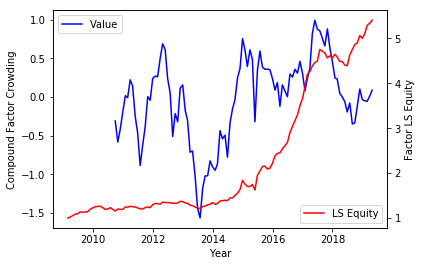

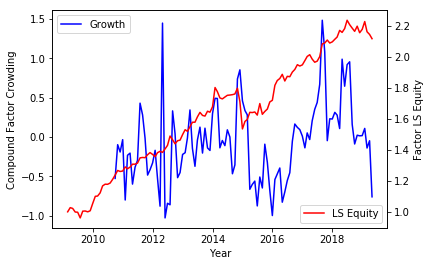

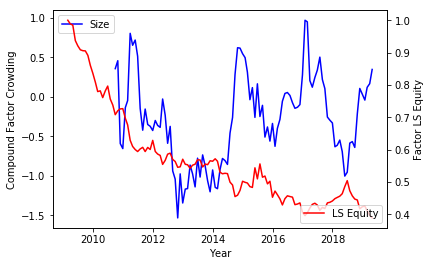

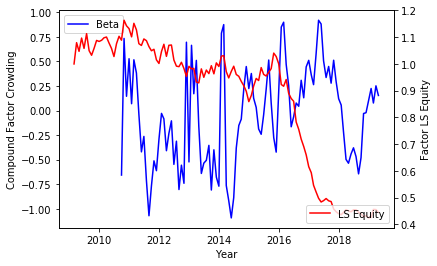

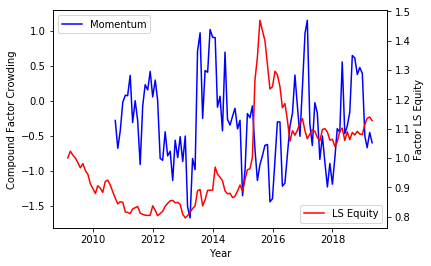

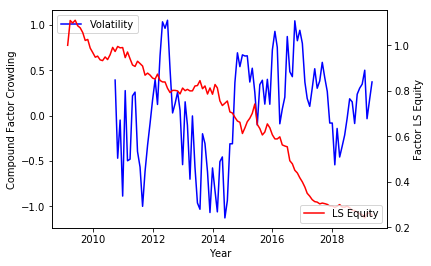

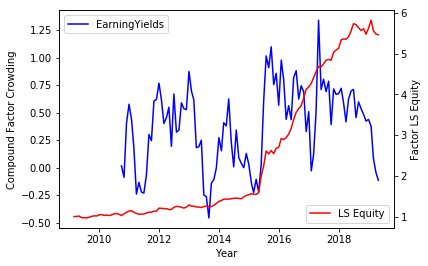

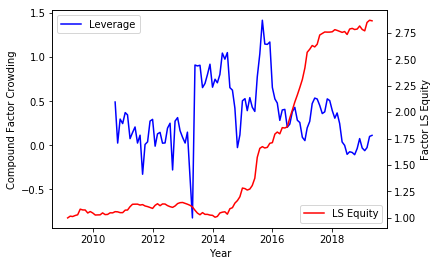

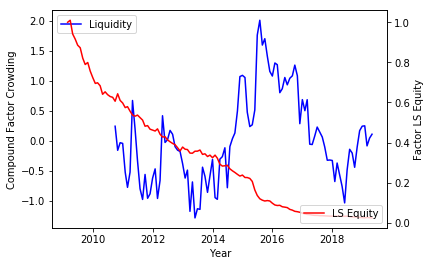

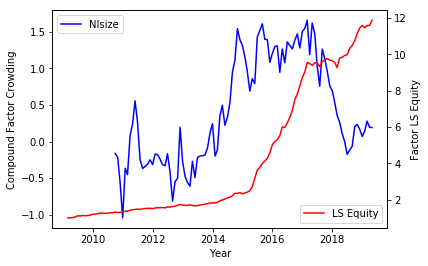

In [138]:
# 因子收益率数据所用df - 来自计算IC序列的多空组合收益结果,收益率的日期是下一期收益需要往后移动一期
reversal_factor_df = Factor_portfolio_save_df.set_index('date').shift(1).reset_index()[['LS'+factor for factor in style_factor]+['date']].set_index('date')
# 因子多空组合净值曲线,多头固定为因子较大值Q5部分
equity_factor_LS = (reversal_factor_df+1).fillna(1).apply(lambda x:np.log(x)).expanding().sum().apply(lambda x:np.exp(x))

# for factor in used_factor_list:
#     plt.figure(figsize=(9, 5))
#     name = 'compound'+factor
#     plt.plot(compound_crowding_result[[name]],label = factor)
#     plt.plot(reversal_factor_df[['LS'+factor]],label = 'R')
#     plt.xlabel('Year')
#     plt.ylabel('Compound Factor Crowding')
#     plt.legend(loc=0)
#     plt.show()
for factor in used_factor_list:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    name = 'compound'+factor
    ax1.plot(compound_crowding_result[[name]],label = factor,color='b')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Compound Factor Crowding')
    ax2.plot(equity_factor_LS[['LS'+factor]],label = 'LS Equity',color='r')
    ax2.set_ylabel('Factor LS Equity')
    ax1.legend(loc=2)
    ax2.legend(loc=4)

In [ ]:
# 还可作进一步序列分析 - 如回归分析等